In [1]:
import yfinance as yf
from pypfopt import expected_returns, EfficientSemivariance, EfficientFrontier, plotting
from pypfopt.risk_models import risk_matrix
import matplotlib.pyplot as plt
import numpy as np
from pypfopt.expected_returns import capm_return
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = yf.download(['AMZN', 'AAPL'], start='2020-01-01', end='2021-01-01')['Adj Close']
data

[*********************100%%**********************]  2 of 2 completed


,AAPL,AMZN
Date,,
2020-01-02,73.152634,94.900497
2020-01-03,72.441444,93.748497
2020-01-06,73.018707,95.143997
2020-01-07,72.675262,95.343002
2020-01-08,73.844337,94.598503
...,...,...
2020-12-24,129.679733,158.634506
2020-12-28,134.317825,164.197998
2020-12-29,132.529388,166.100006


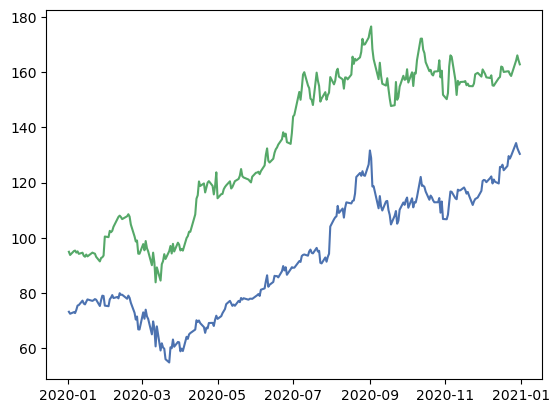

In [3]:
plt.plot(data['AAPL'])
plt.plot(data['AMZN'])

In [4]:
mu = expected_returns.mean_historical_return(data)
historicalReturns = expected_returns.returns_from_prices(data)

In [5]:
mu

AAPL    0.782400
AMZN    0.715971
dtype: float64

In [6]:
historicalReturns

,AAPL,AMZN
Date,,
2020-01-03,-0.009722,-0.012139
2020-01-06,0.007969,0.014886
2020-01-07,-0.004704,0.002092
2020-01-08,0.016086,-0.007809
2020-01-09,0.021241,0.004799
...,...,...
2020-12-24,0.007712,-0.003949
2020-12-28,0.035766,0.035071
2020-12-29,-0.013315,0.011584


In [7]:
S = risk_matrix(data)
S

,AAPL,AMZN
AAPL,0.218083,0.125394
AMZN,0.125394,0.148310


In [8]:
np.sqrt(S)

,AAPL,AMZN
AAPL,0.466994,0.35411
AMZN,0.354110,0.38511


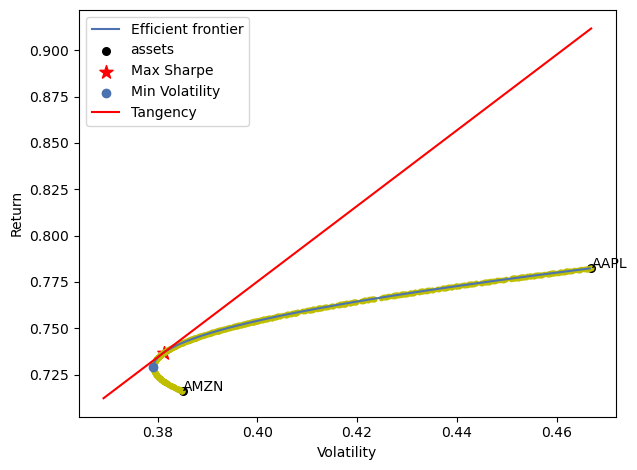

In [9]:
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
efMaxSharpe = ef.deepcopy()
efMinVol = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_tickers=True)
efMaxSharpe.max_sharpe()
retTangent, stdTangent, _ = efMaxSharpe.portfolio_performance()
ax.scatter(stdTangent, retTangent, marker='*', s = 100, c='r', label='Max Sharpe')

Nsamples = 1024
w = np.random.dirichlet(np.ones(ef.n_assets), Nsamples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = (rets - .02) / stds
ax.scatter(stds, rets, marker='.', c='y')

minVolRet = rets[stds.argmin()]
ax.scatter(stds.min(), minVolRet, label='Min Volatility')

X = np.linspace(min(stds) - 0.01, stds.max(), 50)
coefs = np.polyfit([0.02, stdTangent], [0, retTangent], 1)
polynomial = np.poly1d(coefs)
Y = polynomial(X)
ax.plot(X, Y, c='r', label='Tangency')
ax.legend()

1.8804349191917245


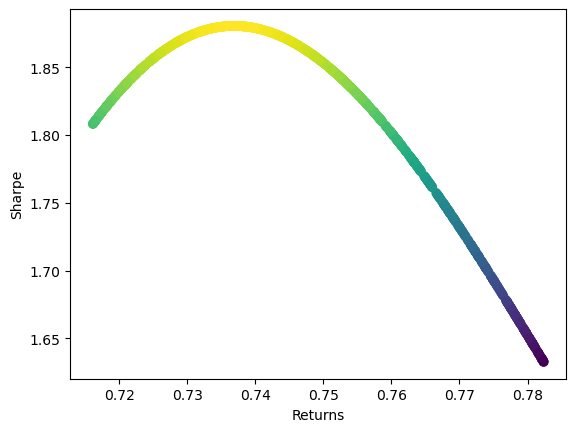

In [10]:
plt.clf()
plt.scatter(rets, sharpes, c = sharpes)
plt.xlabel('Returns')
plt.ylabel('Sharpe')
print(max(sharpes))

In [11]:
efMinVol.min_volatility()

OrderedDict([('AAPL', 0.1982261478510046), ('AMZN', 0.8017738521489954)])

In [12]:
efMinVol.portfolio_performance(verbose=True)

Expected annual return: 72.9%
Annual volatility: 37.9%
Sharpe Ratio: 1.87


(0.7291389194353552, 0.3791663637754487, 1.8702579848441516)

In [13]:
port = efMaxSharpe.portfolio_performance(verbose=True)

Expected annual return: 73.7%
Annual volatility: 38.1%
Sharpe Ratio: 1.88


In [14]:
efMaxSharpe.clean_weights()

OrderedDict([('AAPL', 0.31472), ('AMZN', 0.68528)])